In [1]:
from jax import random
import jax
import neural_tangents as nt
from neural_tangents import stax

2023-08-06 13:18:46.629135: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
init_fn, apply_fn, kernel_fn = stax.serial(
    stax.Dense(1,parameterization = 'ntk')
)

In [3]:
n_train = 100
n_test = 1
d = 100 
key1, key2, key3 = random.split(random.PRNGKey(1), num=3)
output_shape, params = init_fn(key1, input_shape=(d,))
delta = jax.numpy.sqrt(d/n_train) + 1
cov = jax.numpy.identity(d, dtype=None)
cov = cov.at[0,0].set(1+delta)
mean = jax.numpy.zeros(d)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
def returnsXPerturbed(x, epsilon, key):
    noise = random.normal(key, x.shape)
    noise_norm = jax.numpy.linalg.norm(noise, axis=1)
    noise_norm = noise_norm.reshape(noise_norm.shape[0],1)
    normed_noise = epsilon*noise/noise_norm
    x_perturbed = x+normed_noise
    return x_perturbed

In [5]:
def returnsNTkKernel(x_train, kernel_fn, x=None, train=True):
    if train:
        ntk_train_train = kernel_fn(x_train, x_train, 'ntk')
        return ntk_train_train
    ntk_test_train = kernel_fn(x, x_train, 'ntk')
    return ntk_test_train

def EigenDecompositonOfKernel(ntk_train_train):
    eigenvalues, eigenvectors = jax.numpy.linalg.eigh(ntk_train_train)
    return eigenvalues, eigenvectors

def feature(y_train, ntk_test_train, eigenvalues, eigenvectors, i):
    lambda_i, v_i = eigenvalues[i], eigenvectors[i].reshape(eigenvectors[i].shape[0],1)
    output = ntk_test_train @ v_i @ v_i.T @ y_train
    print(output, lambda_i, v_i.T@v_i)
    output = output/lambda_i
    return output

In [6]:
def return_data(epsilon):
    x_train = jax.random.multivariate_normal(key2, mean, cov, (n_train,))
    y_train = random.uniform(key2, shape=(n_train, 1))  # training targets
    x_test = jax.random.multivariate_normal(key3, mean, cov, (n_test,))
    x_perturbed = returnsXPerturbed(x_train, epsilon, key3)
    x_perturbed_test = returnsXPerturbed(x_test, epsilon, key3)
    return x_train, y_train, x_test, x_perturbed, x_perturbed_test

In [7]:
def return_norm(x_train, y_train, x_test, x_perturbed, x_perturbed_test, kernel_fn):
    ntk_matrix_clean = returnsNTkKernel(x_train, kernel_fn, x=None, train=True)
    ntk_matrix_perturbed = returnsNTkKernel(x_perturbed, kernel_fn, x=None, train=True)
    eigenvalues_clean, eigenvectors_clean = EigenDecompositonOfKernel(ntk_matrix_clean)
    eigenvalues_perturbed, eigenvectors_perturbed = EigenDecompositonOfKernel(ntk_matrix_perturbed)
    ntk_eval_clean = returnsNTkKernel(x_train, kernel_fn, x_test, train=False)
    ntk_eval_perturbed = returnsNTkKernel(x_perturbed, kernel_fn, x_perturbed_test, train=False)   
    fx_delta = lambda x: feature(y_train, ntk_eval_perturbed, eigenvalues_clean, eigenvectors_clean, x)
    fx_clean = lambda x: feature(y_train, ntk_eval_clean, eigenvalues_perturbed, eigenvectors_perturbed, x)
    output_delta = map(fx_delta, range(n_train))
    output_clean = map(fx_clean, range(n_train))
    difference =  jax.numpy.array(list(output_delta))-jax.numpy.array(list(output_clean))
    norms = difference.reshape(difference.shape[0])
    return norms, eigenvalues_perturbed, eigenvalues_clean

In [8]:
epsilons = [0.01,0.05,0.1]
eigenvalues_perturbed = []
norms = []
for epsilon in epsilons:
    x_train, y_train, x_test, x_perturbed, x_perturbed_test = return_data(epsilon)
    norm, perturbed, eigenvalues_clean = return_norm(x_train, y_train, x_test, x_perturbed, x_perturbed_test, kernel_fn)
    norms.append(norm)
    eigenvalues_perturbed.append(perturbed)

[[-0.00631796]] 7.095611e-05 [[1.0000002]]
[[0.01006026]] 0.0006529191 [[1.0000002]]
[[0.02221906]] 0.0040896065 [[0.9999999]]
[[-0.00346033]] 0.0061416244 [[0.9999999]]
[[0.00925747]] 0.007242541 [[1.]]
[[0.03577007]] 0.009167087 [[1.0000001]]
[[-0.00559081]] 0.012563073 [[1.0000002]]
[[0.00740644]] 0.013598739 [[1.0000002]]
[[0.1453156]] 0.019534504 [[0.9999999]]
[[-0.09754883]] 0.027679756 [[0.9999996]]
[[0.00525549]] 0.03060871 [[1.0000002]]
[[-0.0746047]] 0.03278659 [[0.99999994]]
[[0.03722779]] 0.041993774 [[1.]]
[[-0.00088477]] 0.043815363 [[0.9999996]]
[[0.03184801]] 0.05119002 [[0.99999964]]
[[0.01761131]] 0.055727832 [[0.9999999]]
[[-0.00225878]] 0.059924982 [[1.0000001]]
[[-0.01105549]] 0.077714674 [[1.]]
[[-0.02813374]] 0.08458264 [[1.0000001]]
[[0.24736655]] 0.09051026 [[0.9999999]]
[[-0.06635721]] 0.09812764 [[0.9999999]]
[[-0.00516343]] 0.1050275 [[0.99999976]]
[[-0.00059069]] 0.12455462 [[1.]]
[[0.02375287]] 0.13258623 [[1.]]
[[-0.1773688]] 0.15113594 [[1.0000004]]
[[0.

[[-0.00698459]] 0.104648866 [[1.0000001]]
[[-5.0526047e-05]] 0.12417337 [[0.9999998]]
[[0.02174107]] 0.13254896 [[1.]]
[[-0.19164176]] 0.15086095 [[0.9999999]]
[[0.2780743]] 0.17446332 [[0.9999998]]
[[-0.11683354]] 0.19065258 [[1.0000001]]
[[0.02372585]] 0.19861892 [[1.0000002]]
[[-0.00570726]] 0.212742 [[1.0000004]]
[[0.08855546]] 0.21986493 [[1.0000001]]
[[0.00351111]] 0.22886164 [[1.0000002]]
[[0.00488675]] 0.2603179 [[1.0000002]]
[[0.05990425]] 0.2715605 [[1.]]
[[0.03957638]] 0.2847404 [[0.9999999]]
[[-0.05034007]] 0.31102887 [[1.]]
[[-0.02355934]] 0.32432032 [[1.0000001]]
[[-0.01239177]] 0.33153632 [[0.9999999]]
[[0.02810005]] 0.34135255 [[1.0000001]]
[[0.02942911]] 0.36227497 [[0.9999996]]
[[0.00284043]] 0.3722227 [[1.0000001]]
[[0.05693932]] 0.3976723 [[1.]]
[[0.00146855]] 0.43967715 [[1.0000002]]
[[0.00664925]] 0.46246615 [[1.0000001]]
[[0.02133995]] 0.4757963 [[0.99999994]]
[[0.00623694]] 0.50507164 [[0.99999994]]
[[-0.01577055]] 0.5517227 [[0.9999998]]
[[0.05719839]] 0.558717

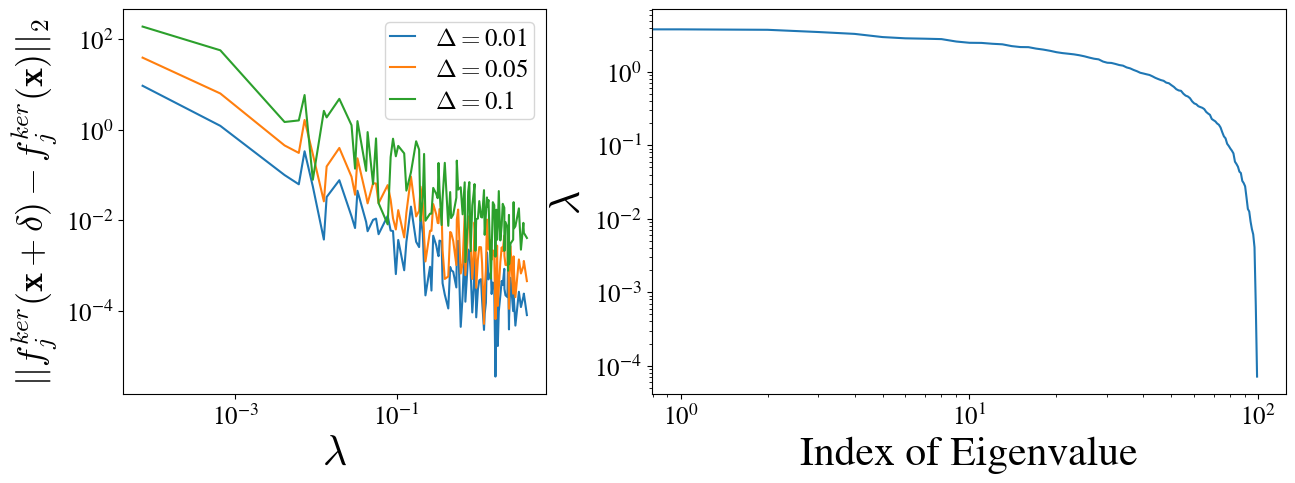

In [12]:
import torch
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
# Matplotlib settings
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rcParams['savefig.dpi'] = 600       
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.formatter.limits']=(-3, 3)
mpl.rcParams['axes.formatter.use_mathtext']=True

mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
mpl.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
mpl.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'

mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['legend.labelspacing'] = 0.3
mpl.rcParams['legend.borderpad'] = 0.2
mpl.rcParams['legend.handlelength'] = 1
fig = plt.figure(figsize=(15,5))
gs = mpl.gridspec.GridSpec(1, 2, width_ratios=[1, 1.5]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
eigenvalues_clean = eigenvalues_clean.sort()
for i in range(len(norms)):
    norm = np.sqrt(norms[i]**2)
    #norm[norm<1e-5]=1e-3
    spline = UnivariateSpline(eigenvalues_clean, norm)
    ax1.plot(eigenvalues_clean, norm, label="$\Delta=$"+str(epsilons[i]))
ax2.plot(eigenvalues_clean[::-1], label="clean")

ax1.set_ylabel("$||f_j^{ker}(\mathbf{x}+\mathbf{\delta})-f_j^{ker}(\mathbf{x})||_2$",fontsize=26)
ax1.set_xlabel("$\lambda$",fontsize=30)
ax2.set_ylabel("$\lambda$",fontsize=30)
ax2.set_xlabel("Index of Eigenvalue",fontsize=30)
ax1.set_yscale("log")
ax1.set_xscale("log")
ax2.set_yscale("log")
ax2.set_xscale("log")
ax1.legend(fontsize=18)
#ax2.legend(fontsize=20)
ax1.tick_params(axis='x', labelsize=18)
ax1.tick_params(axis='y', labelsize=18)
ax2.tick_params(axis='x', labelsize=18)
ax2.tick_params(axis='y', labelsize=18)
plt.show()

In [10]:
!pip install scipy

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: /usr/bin/python3 -m pip install --upgrade pip
